# ROB2004 Final Project - pick and place objects

The goal of this project is to solve a simple manipulation task: picking up objects and moving them in a bowl.

## Instructions
* Answer all questions in the notebook
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a 2-3 pages report in pdf format (pdf only) detailing the methodology you followed to answer the questions as well as answers to the questions that require a typeset answer. You may add the plots in the report (does not count for the page limit) or in the Jupyter notebook.
* This is an individual project

We will use a model of the Frank-Emika Panda robot. This robot has 7 revolute joints and its kinematics is described in the picture below.

You will need to install pybullet on your computer. Please reach out as soon as possible for help if you do not know how to do it.

<div>
<img src="./panda.jpg" width="200"/>
</div>

# Question

Implement a controller using the code skeletong below in order to get the robot to go and pick up the red blocks and drop them in the green bowl. The bowl position is $(-0.3,0.55,0.65)$ (in spatial frame coordinates) and the blocks positions are $(0.35,0.58,0.65)$ and $(0.15,0.67,0.65)$ respectively.

<div>
<img src="./manipulation_scene.jpg" width="300"/>
</div>

You are free to use the methods that you want to solve the task, with the following constraints:
* You cannot use any external library apart from numpy and scipy
* You need to use at least one controller in the end-effector space
* You need to generate smooth motions
* You need to compensate for the gravity of the robot

In your report, describe the controller and justify your choices. Analyze the behavior of the system (include plots of the end-effector trajectories, velocities, joint trajectories, etc as you see fit).

In [1]:
import numpy as np
import time

import matplotlib.pyplot as plt

from panda import Simulator, PandaRobot

np.set_printoptions(precision=4, suppress = True)

# Helper functions

We provide a set of helper functions (forward kinematics, Jacobians, gravity terms) that can be used to implement the desired controllers. These functions are implemented in the PandaRobot class (in the panda.py file).
Examples are shown below:

In [2]:
# create an instance of the helper class
my_robot = PandaRobot()

# compute the forward kinematics for an arbitrary joint configuration
q = np.random.uniform(-1,1,7)
pose = my_robot.FK(np.array([0.,0,0.0,-np.pi/2.,0.,np.pi/2.,0.0]))
print(f'the pose of the end-effector for joint configuration\n\n {q}\n\n is\n\n {pose}')

the pose of the end-effector for joint configuration

 [-0.7077  0.8536 -0.8974 -0.6584  0.9994 -0.4894  0.849 ]

 is

 [[-0.7071  0.7071  0.      0.    ]
 [ 0.7071  0.7071 -0.      0.5545]
 [-0.      0.     -1.      0.6245]
 [ 0.      0.      0.      1.    ]]


In [3]:
# we can also get the Jacobian in various frames 
# it is sufficient to pass the name of the frame as an argument as shown below

q = np.random.uniform(-1,1,7)

spatial_jacobian = my_robot.get_jacobian(q, 'S')
body_jacobian = my_robot.get_jacobian(q, 'B')

# we can even get the Jacobian in a frame place at the same position as the end-effector 
# frame but oriented like the spatial frame
oriented_jacobian = my_robot.get_jacobian(q, 'O')

print(f'for joint configuration \n\n {q} \n \n the spatial Jacobian is \n\n {spatial_jacobian}\n\n')
print(f'the body Jacobian is \n\n {body_jacobian}\n\n')
print(f'and the Jacobian in a frame placed at the same position as the end-effector but oriented like the spatial frame is\n\n {oriented_jacobian}')

for joint configuration 

 [ 0.313  -0.5951  0.0183  0.9999 -0.6376  0.794  -0.374 ] 
 
 the spatial Jacobian is 

 [[ 0.     -0.9514  0.1726  0.9466  0.3225  0.7618  0.1746]
 [ 0.     -0.308  -0.5334  0.3223 -0.9463  0.2746  0.7852]
 [ 1.      0.      0.8281  0.0103 -0.0241 -0.5868  0.5941]
 [ 0.      0.1025  0.1776 -0.2077  0.5309  0.1222 -0.7746]
 [ 0.     -0.3168  0.0575  0.6063  0.1809  0.5099 -0.021 ]
 [ 0.      0.     -0.      0.1088  0.0023  0.3972  0.2554]]


the body Jacobian is 

 [[ 0.7579  0.5727  0.8027 -0.5696  0.2852 -0.9165  0.    ]
 [ 0.2696 -0.711   0.5873  0.7038  0.6537  0.3999  0.    ]
 [ 0.5941 -0.408   0.1034  0.4245 -0.701   0.      1.    ]
 [-0.3017  0.2611 -0.1079 -0.2785  0.1265  0.0428  0.    ]
 [ 0.2853 -0.0838  0.1185 -0.0849 -0.0552  0.0981 -0.    ]
 [ 0.2554  0.5126  0.1651 -0.2329  0.     -0.088  -0.    ]]


and the Jacobian in a frame placed at the same position as the end-effector but oriented like the spatial frame is

 [[ 0.     -0.9514  0.1726  0.

In [4]:
# finally it is possible to compute the effect of gravity on the joints
# this can for example be used to do gravity compensation when controlling the robot

q = np.random.uniform(-1,1,7)

g = my_robot.g(q)

print(f'for joint configuration \n\n {q} \n \n the gravity force seen on the joints is \n \n {g}')

for joint configuration 

 [-0.1101 -0.1356 -0.8768 -0.8122  0.0321 -0.5049 -0.5797] 
 
 the gravity force seen on the joints is 
 
 [-0.     -5.4807  2.0497 11.1379  0.0636 -0.3408  0.    ]


In [5]:
def compute_trajectory(position_init, position_goal, t_init, t_goal, t):
    desired_position = 0
    desired_velocity = 0
    T = t_goal - t_init
    t_c = t - t_init
    
    desired_position = position_init + ((10/T**3)*(t_c**3) + (-15/T**4)*(t_c**4) + (6/T**5)*(t_c**5))*(position_goal-position_init)
    
    desired_velocity = ((30/T**3)*(t_c**2) + (-60/T**4)*(t_c**3) + (30/T**5)*(t_c**4))*(position_goal-position_init)
    
    # we return the answer
    return desired_position, desired_velocity

In [6]:
def pseudo_inv(jacobian):
    pseudo_inv = jacobian.T @ np.linalg.inv(jacobian @ jacobian.T)
    return pseudo_inv

# Code Skeleton for the simulation

Feel free to change the `run_time` variable to match your needs. The class `Simulator` contains all the code for the simulation. The code skeleton currently implement a simple PD controller in joint space that just keeps a desired current position.

Importantly you can control both the joints and the gripper of the robot:
* `simulator.send_joint_torque(joint_torques)` sends a vector of dimension 7 setting the torques of the joints
* `simulator.gripper_move(gripper_position)` sends a vector of dimension 2 setting the position of the fingers of the gripper. The fingers can have positions from 0 to 0.04cm (you can fully close the gripper by setting `simulator.gripper_move([0,0])` and fully open it by setting `simulator.gripper_move([0.04,0.04)`)

In [7]:
# here we create a simulation and reset the state of the robot
simulator = Simulator()
simulator.reset_state([0.,0,0.0,-np.pi/2.,0.,np.pi/2.,0.0])


q__desired_pose = np.array([0.,0,0.0,-np.pi/2.,0.,np.pi/2.,0.0])
# we create a robot object so we can use its helper functions
my_robot = PandaRobot()

# duration of the simulation
run_time = 30.

# simulation time step
dt = 0.005
num_steps = int(run_time/dt)


# we store information
ndofs = 7 # number of degrees of freedom (excluding the gripper)
measured_positions = np.zeros([num_steps,ndofs])
measured_velocities = np.zeros_like(measured_positions)
desired_torques = np.zeros_like(measured_positions)
desired_positions = np.zeros_like(measured_positions)
desired_velocities = np.zeros_like(measured_positions)
time = np.zeros([num_steps])

measured_finger_position = np.zeros([num_steps,3])
desired_finger_position = np.zeros([num_steps,3])
measured_finger_velocity = np.zeros([num_steps,3])
desired_finger_velocity = np.zeros([num_steps,3])


time_to_goal = run_time/7.

target_number = 0


x_ref = np.array([0.0, 0.0, 0.0])
dx_ref = np.array([0.0, 0.0, 0.0])


gripper_position = [0.04, 0.04]

### this is the main control loop
for i in range(num_steps):
    # get the current time and save it
    time[i] = dt * i
    
    # we get the position and velocities of the joints
    q, dq = simulator.get_state()
    measured_positions[i,:] = q
    measured_velocities[i,:] = dq
    
    # save the current position of the fingertip using the FK function
    pose = my_robot.FK(q)
    measured_finger_position[i,:] = pose[0:3,3]
    
    
    target_positions = [np.array([0.15,0.67,0.65]),np.array([0.15,0.67,0.3]),np.array([-0.3,0.55,0.65]),np.array([0.35,0.58,0.65]), np.array([0.35,0.58,0.3]),np.array([-0.3,0.55,0.65]),measured_finger_position[0,:]]

    
    
    ## controller: TODO HERE IMPLEMENT YOUR CONTROLLER TO SOLVE THE TASK
    ## you will need to replace the naive PD controller implemented below
    
    
    
    t1new = target_positions[target_number][0]
    t2new = target_positions[target_number][1]
    t3new = target_positions[target_number][2]
    
    if (target_number == 0):
        t1old = measured_finger_position[0,0]
        t2old = measured_finger_position[0,1]
        t3old = measured_finger_position[0,2]

    
    if (time[i] <= time_to_goal*(target_number+1)):
        t_init = target_number*time_to_goal
        t_goal = time_to_goal*(target_number+1)
        
        x_ref[0],dx_ref[0] = compute_trajectory(t1old,t1new,t_init,t_goal,time[i])
        x_ref[1],dx_ref[1] = compute_trajectory(t2old,t2new,t_init,t_goal,time[i])
        x_ref[2],dx_ref[2] = compute_trajectory(t3old,t3new,t_init,t_goal,time[i])
        
    else:
        if (target_number == 1 or target_number == 4):
            gripper_position = [0., 0.]
        else:
            gripper_position = [0.04, 0.04]
        
        target_number += 1
        t1old = t1new
        t2old = t2new
        t3old = t3new
        
       
    
    P = np.array([100., 100., 50.])
    
    oriented_jacobian = my_robot.get_jacobian(q, 'O')
    oriented_jacobian = oriented_jacobian[3:,:]
    
    measured_finger_velocity[i,:] = oriented_jacobian @ dq
    
    
    v_o = dx_ref + P*(x_ref - measured_finger_position[i,:])
    v_o = np.array([[v_o[0]],[v_o[1]],[v_o[2]]])
    dq_des = pseudo_inv(oriented_jacobian) @ v_o
    dq_des = dq_des[:,0]
    
    null_P = np.eye(7) - pseudo_inv(oriented_jacobian) @ oriented_jacobian
    
    # we compute the error between joint position and our desired ones (nullspace task)
    P_posture = 1. # the gain for the posture task
    null_q = P_posture * (q__desired_pose - q)
    
    ##Resolved Rate Controller
    
    dq_des = dq_des + null_P @ null_q
    
    D = np.array([10.,10,10,10,10,10,1.])

    d_error = dq_des-dq # the velocity error for all the joints
    
    desired_finger_position[i,:] = x_ref
    desired_finger_velocity[i,:] = dx_ref
    
    
    # we compute the desired torques as a PD controller
    joint_torques =  D*d_error + my_robot.g(q)
    
    simulator.send_joint_torque(joint_torques)

    simulator.gripper_move(gripper_position)
    simulator.step()

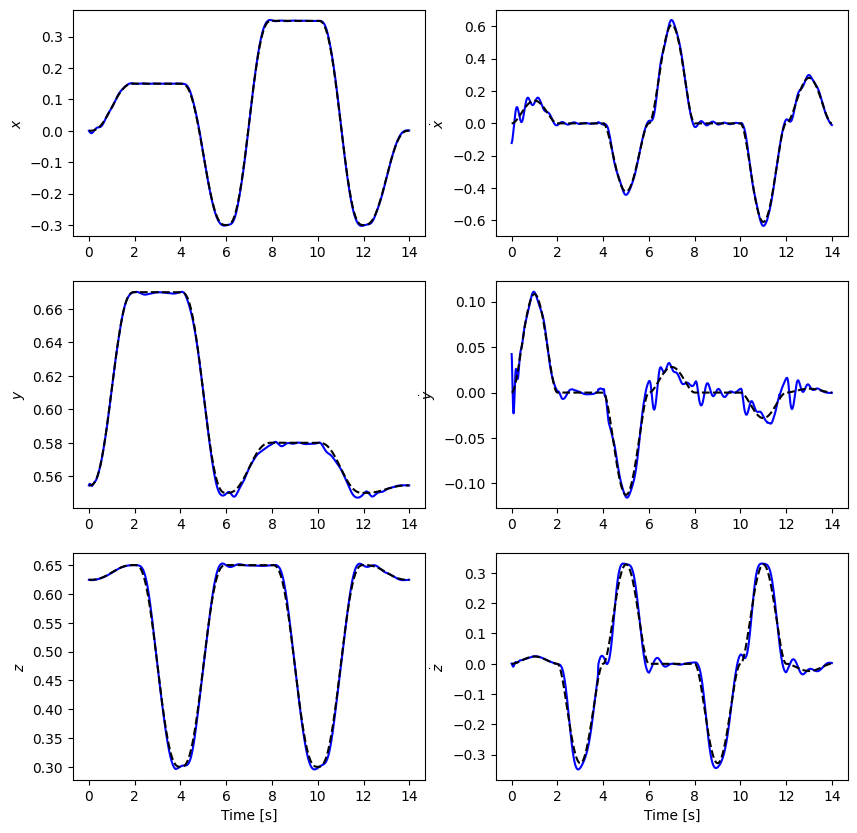

In [8]:
def plot_joint_posvel(time, th, th_des, dth, dth_des):
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(3,2,1)
    plt.plot(time, th[:,0], 'b-', time, th_des[:,0], '--k')
    plt.ylabel(r'$x$')
    plt.subplot(3,2,3)
    plt.plot(time, th[:,1], 'b-', time, th_des[:,1], '--k')
    plt.ylabel(r'$y$')
    plt.subplot(3,2,5)
    plt.plot(time, th[:,2], 'b-', time, th_des[:,2], '--k')
    plt.ylabel(r'$z$')
    plt.xlabel('Time [s]')
    
    plt.subplot(3,2,2)
    plt.plot(time, dth[:,0], 'b-', time, dth_des[:,0], '--k')
    plt.ylabel(r'$\dot{x}$')
    plt.subplot(3,2,4)
    plt.plot(time, dth[:,1], 'b-', time, dth_des[:,1], '--k')
    plt.ylabel(r'$\dot{y}$')
    plt.subplot(3,2,6)
    plt.plot(time, dth[:,2], 'b-', time, dth_des[:,2], '--k')
    plt.ylabel(r'$\dot{z}$')
    plt.xlabel('Time [s]')
    
plot_joint_posvel(time, measured_finger_position, desired_finger_position, measured_finger_velocity, desired_finger_velocity)

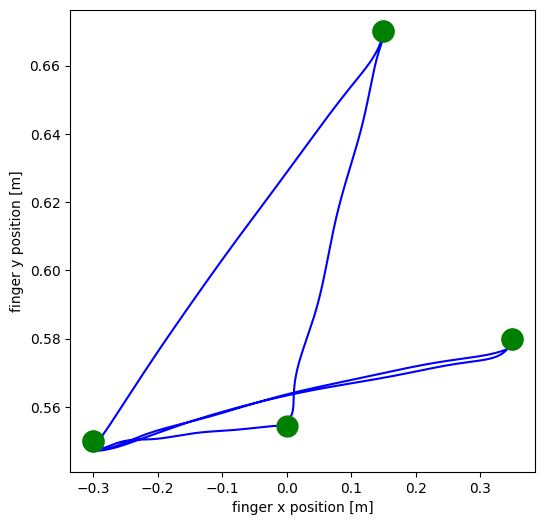

In [9]:
def plot_finger_trajectory_xy(finger_position):
    """
    plots the position of the finger in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.plot(finger_position[:,0],finger_position[:,1], 'b')
    plt.xlabel('finger x position [m]')
    plt.ylabel('finger y position [m]')
    i = 0
    for target in target_positions:
        plt.plot([target[0]],[target[1]],'o',markersize=15,color='g')
        i += 1

plot_finger_trajectory_xy(measured_finger_position)

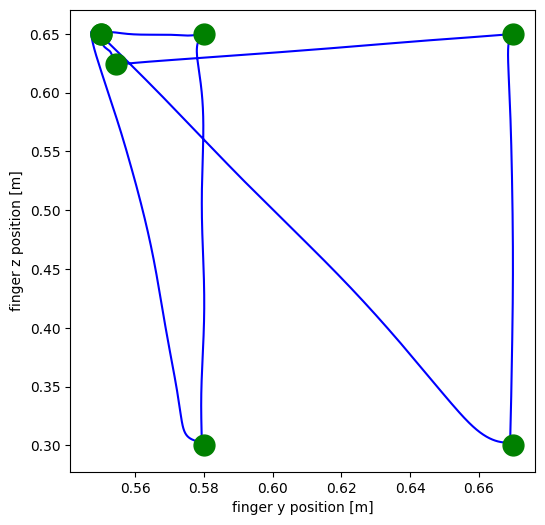

In [10]:
def plot_finger_trajectory_yz(finger_position):
    """
    plots the position of the finger in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.plot(finger_position[:,1],finger_position[:,2], 'b')
    plt.xlabel('finger y position [m]')
    plt.ylabel('finger z position [m]')
    i = 0
    for target in target_positions:
        plt.plot([target[1]],[target[2]],'o',markersize=15,color='g')
        i += 1

plot_finger_trajectory_yz(measured_finger_position)

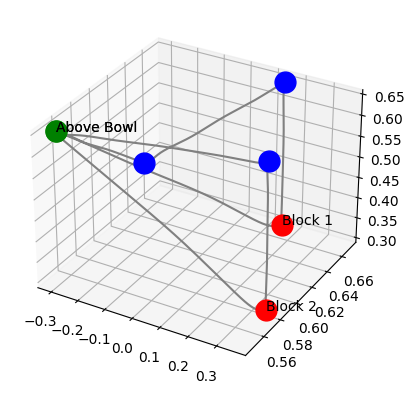

In [11]:
def threeDplot(finger_position):
    ax = plt.axes(projection='3d')
    xline = finger_position[:,0]
    yline = finger_position[:,1]
    zline = finger_position[:,2]
    ax.plot3D(xline, yline, zline, 'gray')
    i = 0
    for target in target_positions:
        if i == 1:
            plt.plot([target[0]],[target[1]],[target[2]],'o',markersize=15,color='r')
            ax.text(target[0],target[1],target[2], 'Block 1') 
        elif i == 2 or i == 5:
            plt.plot([target[0]],[target[1]],[target[2]],'o',markersize=15,color='g')
            ax.text(target[0],target[1],target[2], 'Above Bowl') 
        elif i == 4:
            plt.plot([target[0]],[target[1]],[target[2]],'o',markersize=15,color='r')
            ax.text(target[0],target[1],target[2], 'Block 2') 
        else:
            plt.plot([target[0]],[target[1]],[target[2]],'o',markersize=15,color='b')
        i += 1
    
threeDplot(measured_finger_position)